# Decision Tree

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import time
import pickle
from collections import defaultdict 

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Nos modules
from modules.decision_tree import OurDecisionTreeClassifier
import modules.scoring as sc
import modules.feature_selection as fs
import modules.params_tuning as pt

## 1. Importation des données

In [2]:
data = pd.read_csv("data.csv")

In [3]:
print(data.shape)
data.head()

(1000, 32)


,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,spectral_contrast,spectral_flatness,tonnetz,estimated_tempo,genre/label
0,country.00094,0.366838,0.206715,1474.849928,1745.839794,3108.264538,0.062993,-104.34503,136.39078,-20.945368,...,2.197093,-7.109390,1.849674,1.675598,-1.492039,23.567712,0.001825,0.026578,112.347147,country
1,country.00025,0.347253,0.079920,1565.431223,2016.069774,3188.930717,0.057303,-200.55273,119.67490,-3.610737,...,-11.293138,-8.870809,-8.073557,-3.161044,0.330751,19.845071,0.008667,0.018447,143.554688,country
2,country.00076,0.297332,0.128385,1321.679067,1409.586676,2590.392670,0.066525,-183.93301,159.80644,-23.158834,...,-3.583324,-9.062474,-3.159365,-4.068544,-7.052489,23.526738,0.001220,-0.013900,143.554688,country
3,country.00030,0.221390,0.079631,1240.515214,1996.754074,2412.635411,0.042844,-277.08127,128.25803,42.433240,...,1.391878,3.080010,2.513260,-1.051766,-2.753359,22.093318,0.002381,-0.009946,161.499023,country
4,country.00089,0.322114,0.104638,1321.678546,1667.211777,2583.926042,0.052503,-205.12328,140.99438,-8.959963,...,3.140506,-4.527332,2.654261,-3.122376,-10.710899,24.189410,0.001850,0.002900,143.554688,country


In [4]:
# On supprime la premiere colonne
data = data.drop(['filename'],axis=1)

# On change les noms des genres par des entiers (de 0 a 9)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
labels = encoder.fit_transform(genre_list)
data.iloc[:, -1] = labels

Puis on normalise le jeu de données.

In [5]:
# On normalise le dataset
scaler = StandardScaler()
data_normalized = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## 2. Apprentissage du modèle de base
On reprend le modèle que nous avions implementé lors du précédent projet. Notre arbre de décision a trois paramètres :
   - `n_cuts` -- le nombre de coupes à tester pour trouver la meilleure
   - `max_depth` -- la profondeur maximale de chaque arbre
   - `max_features` -- le nombre de caractéristiques à choisir lors de l'entraînement du modèle

On sépare tout d'abord le jeu de données pour constituer un ensemble d'apprentissage et de validation.

In [6]:
# On separe le dataset en train set et test set (80%/20%)
data_train, data_test, label_train, label_test = train_test_split(data_normalized, labels, test_size=0.2)
n_samples, n_features = data_train.shape

print("data_train {0} | label_train {1}".format(data_train.shape, label_train.shape))
print("data_test  {0} | label_test  {1}".format(data_test.shape, label_test.shape))

data_train (800, 30) | label_train (800,)
data_test  (200, 30) | label_test  (200,)


On entraîne le modèle de base, dont les paramètres par défaut sont :

        n_cuts = 40
        max_depth = 20
        max_features = 'sqrt'


In [7]:
# Instanciation de l'arbre de decision
base_model = OurDecisionTreeClassifier() 

# Entrainement du modèle de base
start = time.time()
base_model.fit(data_train, label_train)
end = time.time()
print("Execution time to build the decision tree: %f sec"%(float(end) - float(start)))

# Test de validation
base_model_predictions = base_model.predict(data_test)
base_model.score_ = sc.accuracy_score(base_model_predictions, label_test) * 100

Execution time to build the decision tree: 3.425860 sec


Puis on compare la performance de notre decision tree avec celle de scikit-learn.

In [8]:
# Comparaison avec sklearn
sklearn_dt = DecisionTreeClassifier(max_depth=20, max_features='sqrt')
sklearn_dt.fit(data_train, label_train)
sklearn_predictions = sklearn_dt.predict(data_test)

In [9]:
print("Our decision tree score : {} %".format(base_model.score_))
print("Sklearn score : {} %".format(sc.accuracy_score(sklearn_predictions, label_test)*100))

Our decision tree score : 28.999999999999996 %
Sklearn score : 52.0 %


## 3. Wrapper-based Feature Selection
Un moyen d'améliorer notre modèle est de sélectionner les caractéristiques les plus discriminantes. 

* https://towardsdatascience.com/de-coding-random-forests-82d4dcbb91a1
* https://hub.packtpub.com/4-ways-implement-feature-selection-python-machine-learning/

In [10]:
print("Shape of the dataset ", data_train.shape)
print("Size of the dataset before feature selection: %.2f MB"%(data_train.nbytes/1e6))
features_name = data.drop(['genre/label'], axis=1).columns

Shape of the dataset  (800, 30)
Size of the dataset before feature selection: 0.19 MB


In [11]:
start = time.time()
features, importances = fs.findFeatureImportance(base_model, data_train, label_train)
end = time.time()
print("Execution time to find the most important feature: %f sec"%(float(end) - float(start)))

Execution time to find the most important feature: 0.552543 sec


In [12]:
feature_importances = pd.DataFrame(zip(features_name, importances), columns = ['feature','importance']).sort_values('importance', ascending=False)

feature_importances[:10]

,feature,importance
3,spectral_bandwidth,0.29500
5,zero_crossing_rate,0.25625
21,mfcc16,0.23750
15,mfcc10,0.14000
8,mfcc3,0.14000
29,estimated_tempo,0.12500
6,mfcc1,0.00000
7,mfcc2,0.00000
28,tonnetz,0.00000
27,spectral_flatness,0.00000


On selectionne les caracteristiques dont l'importance est superieure a 0.01

In [13]:
# On selectionne les caracteristiques dont l'importance est superieur a 0
indexes = feature_importances[feature_importances['importance'] > 0.01].index

# On transforme le dataset d'entrainement (fs = feature selection)
fs_data_train = fs.transform(data_train, indexes)
fs_data_test = fs.transform(data_test, indexes)

print("Shape of the dataset ", fs_data_train.shape)
print("Size of the dataset after feature selection: %.2f MB"%(fs_data_train.nbytes/1e6))

Shape of the dataset  (800, 6)
Size of the dataset after feature selection: 0.04 MB


On entraîne le modèle de base avec les caractéristiques sélectionnées.

In [14]:
# Instanciation d'un arbre de décision
# Hyperparametres par defaut : n_cuts = 40, max_depth = 20
fs_base_model = OurDecisionTreeClassifier() 
fs_base_model.max_features = len(indexes)

# Entrainement du modèle de base avec feature selection
start = time.time()
fs_base_model.fit(fs_data_train, label_train)
end = time.time()
print("Execution time for building the forest: %f sec"%(float(end) - float(start)))

# Test de validation
fs_base_model_predictions = fs_base_model.predict(fs_data_test)
fs_base_model.score_ = sc.accuracy_score(fs_base_model_predictions, label_test) * 100

Execution time for building the forest: 3.358544 sec


In [15]:
# Comparaison avec sklearn
sklearn_dt.fit(fs_data_train, label_train)
fs_sklearn_predictions = sklearn_dt.predict(fs_data_test)

On compare les scores obtenus avant et après la sélection des caractéristiques.

In [16]:
# Score
print("Before feature selection")
print("Our decision tree score : {} %".format(base_model.score_))
print("Sklearn score : {} %\n".format(sc.accuracy_score(sklearn_predictions, label_test)*100))

print("After feature selection")
print("Our decision tree score : {} %".format(fs_base_model.score_))
print("Sklearn score : {} %".format(sc.accuracy_score(fs_sklearn_predictions, label_test)*100))   

Before feature selection
Our decision tree score : 28.999999999999996 %
Sklearn score : 52.0 %

After feature selection
Our decision tree score : 34.5 %
Sklearn score : 35.0 %


Les scores après la sélection de caractéristisques est plus bas. Dans la suite, nous allons donc chercher le meilleur modèle à partir de l'ensemble d'apprentissage de départ `data_train` 

## 4. Réglage des hyperparamètres
Nous nous sommes fortement inspiré de la méthode décrite dans cet article [W. Koehrsen. Hyperparameter Tuning the Random Forest in Python, Janv. 2018](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

Notre modèle a trois paramètres que nous souhaitons optimiser  :
   - `n_cuts` -- le nombre de coupes à tester pour trouver la meilleure
   - `max_depth` -- la profondeur maximale de chaque arbre
   - `max_features` -- le nombre de caractéristiques à choisir lors de l'entraînement du modèle

### 4.1 Random Search Cross Validation

Pour avoir une première idée de la meilleure combinaison d'hyperparamètres, nous allons effectuer une Random Search Cross Validation. Cela consiste à tester un large choix de combinaisons qui ont été formées en tirant aléatoirement des valeurs dans une grille d'hyperparamètres.

On définit la grille pour la recherche aléatoire (Random Hyperparameter Grid) :

In [17]:
# n_cuts
n_cuts = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)] 

# max_depth
max_depth = [int(x) for x in np.linspace(10, 40, num = 4)]

# max_features
max_features = [int(x) for x in np.linspace(10, n_features, num = 5)]
max_features.append("sqrt")


# Creation de la grille
random_grid = {'n_cuts': n_cuts,
                'max_depth': max_depth,
                'max_features': max_features}

from pprint import pprint
print("Grille d'hyperparametres :\n")
pprint(random_grid)

Grille d'hyperparametres :

{'max_depth': [10, 20, 30, 40],
 'max_features': [10, 15, 20, 25, 30, 'sqrt'],
 'n_cuts': [10, 20, 30, 40, 50]}


Au lieu de tester 5 x 4 x 5 = 100 combinaisons d'hyperparamètres, nous allons seulement en sélectionner quelques unes aléatoirement. On procède à la recherche randomisée sur 50 combinaisons, en utilisant une 5-fold CV.

In [18]:
# 8-10 MIN
# Definition de la recherche randomisee
random_dtc = pt.RandomizedSearchCV(estimator = OurDecisionTreeClassifier, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 5)

# Entrainement du modele
start = time.time()
random_dtc.fit(data_train, label_train)
end = time.time()
print("Execution time for random search training: %f sec"%(float(end) - float(start)))

Execution time for random search training: 468.045623 sec


On affiche les meilleurs hyperparamètres résultant de la recherche randomisée :

In [19]:
print("The best hyperparameters from Random Search are:\n", random_dtc.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(random_dtc.best_score_ * 100))

The best hyperparameters from Random Search are:
 {'n_cuts': 40, 'max_depth': 40, 'max_features': 30}

The mean accuracy of a model with these hyperparameters is:
 51.62


### 4.2 Grid Search Cross Validation
On peut maintenant effectuer une recherche plus exhaustive centrée sur ces valeurs.

In [20]:
# Definition de la grille d'hyperparamètres basée sur les résultats de la recherche randomisée
n_cuts = [35,40,45]
max_depth = [35,40,45]
max_features = [25,30]

param_grid = {
    'n_cuts': n_cuts,
    'max_depth': max_depth,
    'max_features': max_features,
}

In [21]:
# 4-5 MIN
# Instanciation du grid search model
grid_search_dtc = pt.GridSearchCV(estimator = OurDecisionTreeClassifier, 
                                  param_distributions = param_grid,
                                  cv = 5)

# Entrainement du modele
start = time.time()
grid_search_dtc.fit(data_train, label_train)
end = time.time()
print("Execution time for random search training: %f sec"%(float(end) - float(start)))

Execution time for random search training: 235.946723 sec


La meilleur combinaison d'hyperparamètres est :

In [22]:
print("The best hyperparameters from Grid Search are:\n", grid_search_dtc.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:\n %.2f"%(grid_search_dtc.best_score_ * 100))

The best hyperparameters from Grid Search are:
 {'n_cuts': 40, 'max_depth': 45, 'max_features': 30}

The mean accuracy of a model with these hyperparameters is:
 52.62


On sauvegarde le meilleur modèle dans `best_dtc` :

In [23]:
best_dtc = grid_search_dtc.best_estimator_

## 5. Apprentissage du meilleur modèle et performance

Maintenant que nous avons le meilleur modèle, entraînons-le et observons ses performances.

In [24]:
# Entrainement du meilleur modele
best_dtc.fit(data_train, label_train)

# Test de validation
best_dtc_predictions = best_dtc.predict(data_test)
best_dtc.score_ = sc.accuracy_score(best_dtc_predictions, label_test) * 100

### Matrice de confusion

In [25]:
d = {
    'genre': genre_list,
    'genre_code': labels
}
df_genre = pd.DataFrame(d).drop_duplicates().sort_values('genre_code')
df_genre

,genre,genre_code
800,blues,0
900,classical,1
0,country,2
500,disco,3
400,hiphop,4
700,jazz,5
100,metal,6
600,pop,7
200,reggae,8
300,rock,9


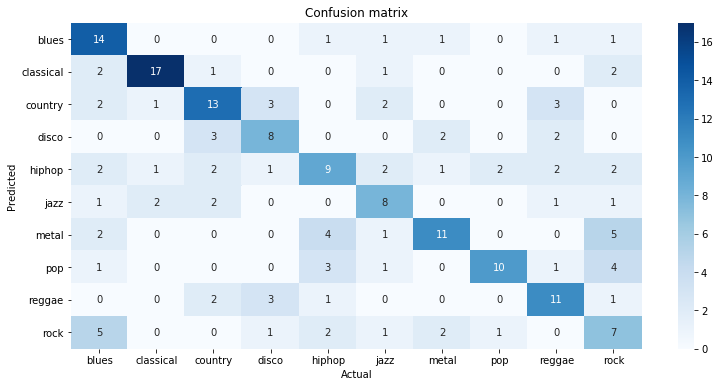

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(label_test, best_dtc_predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=df_genre['genre'].values,
            yticklabels=df_genre['genre'].values,
            cmap="Blues")
            
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Voyons si le réglage des hyperparamètres a permis d'obtenir un meilleur modèle.

In [27]:
print("Base model score: {} %".format(base_model.score_))
print("Best model score: {} %".format(best_dtc.score_ ))

Base model score: 28.999999999999996 %
Best model score: 54.0 %


Sauvegardons le score du modèle pour pouvoir le comparer aux autres modèles.

In [28]:
d = {
    'Model': 'Decision Tree',
    'Test Set Accuracy': best_dtc.score_
}

df_models_dtc = pd.DataFrame(d, index=[0])

In [29]:
with open('Models/best_dtc.pickle', 'wb') as output:
    pickle.dump(best_dtc, output)

with open('Models/df_models_dtc.pickle', 'wb') as output:
    pickle.dump(df_models_dtc, output)